# Functions

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat

%matplotlib inline
# import logging
# logging.getLogger().setLevel(logging.CRITICAL)

In [19]:
dt = 0.01
sampling_rate = 20000

Mean = 10
amp_list = [0.5,1,1.5,2,3]
channelnumbers = [30, 32, 26, 15]

c1 = 0
Spike_list = [0]*len(amp_list)
x_list = [0]*len(amp_list)
# Spike_list = [0]*len(amp_list)
for amp in amp_list:
    filename = 'diode_OU_tau=500ms_cutoff=1_mean='+str(Mean)+'_amp='+str(amp)+'_11-Aug-2021_0'
    annots = loadmat(filename)
    TimeStamps = np.squeeze(annots['TimeStamps'])
    x = annots['a_data'][0, int(TimeStamps[0]*sampling_rate):int(TimeStamps[1]*sampling_rate)+1]
    # x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/5), mode='reflect')
    x = x[::int(sampling_rate*dt)]
    x_list[c1] = x.astype(float)


    Spike_list[c1] = [0]*len(channelnumbers)
    c2=0
    for channelnumber in channelnumbers:
        Spike = np.squeeze( annots['Spikes'][0][channelnumber-1]-TimeStamps[0] )
        Spike = np.delete(Spike, np.where(Spike<=0))
        Spike_list[c1][c2] = Spike.copy()
        c2+=1
        # print(str(Mag)+'; '+str(len(Spike)/300))
    c1+=1

Spike2DList = np.array(Spike_list)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# Event Plot

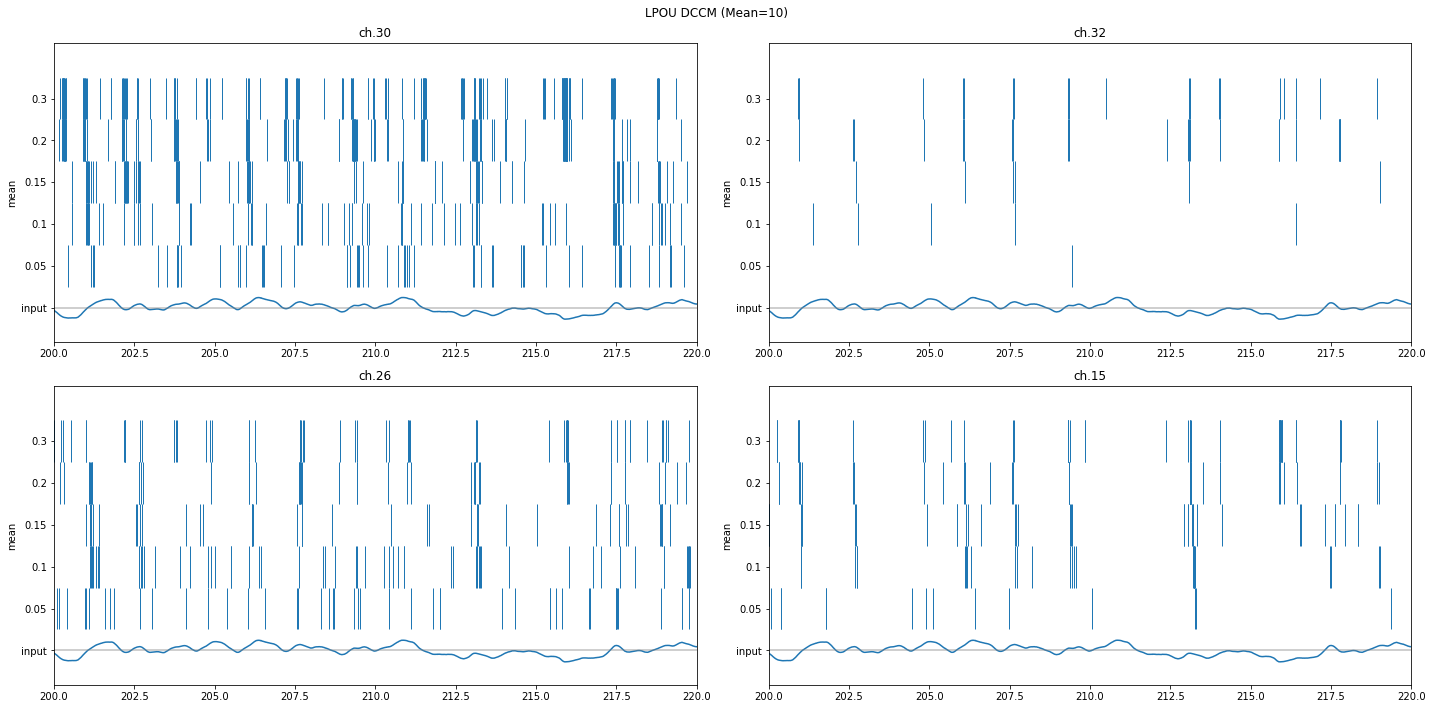

In [20]:
fig, ax = plt.subplots(2,2)
c2=0
fig.suptitle('LPOU DCCM (Mean=10)')
for channelnumber in channelnumbers:
    ax.flatten()[c2].plot(np.arange(len(x))*dt, (x-min(x))/(max(x)-min(x))-1.5)
    ax.flatten()[c2].axhline(-1, c='gray', alpha = 0.5)
    ax.flatten()[c2].eventplot(Spike2DList[:,c2], linewidths=1)
    ax.flatten()[c2].set_yticks(np.arange(-1,len(amp_list)))
    ax.flatten()[c2].set_yticklabels(['input', '0.05', '0.1', '0.15', '0.2','0.3'])
    ax.flatten()[c2].set_title('ch.'+str(channelnumber))
    ax.flatten()[c2].set_ylabel('mean')
    # plt.xlim(0,50)
    ax.flatten()[c2].set_xlim(200,220)
    
    c2+=1
fig.set_size_inches(20, 10)
fig.tight_layout()

## Sychronize Index [ event_count / tatal_num ]

In [ ]:
def synchIndex(testSpike, refSpike, tolerance):
    numerator = 0 # numerator = number of spikes in testSpike which there is also a spike in refSpike in the range of tolerance around.
    denominator = 0 # denominator = number of spikes in testSpike
    for spike in testSpike:
        denominator+=1
        if np.sum((refSpike>=(spike-tolerance)) & (refSpike<=(spike+tolerance))) > 0:
            numerator+=1
    return numerator/denominator

In [21]:
tolerance = 5*dt

synchMatrix = np.ones((len(amp_list),len(amp_list),len(channelnumbers)))
for ch in range(len(channelnumbers)):
    for i1 in range(len(amp_list)):
        for i2 in range(len(amp_list)):
            if i1==i2: continue
            synchMatrix[i1,i2,ch] = synchIndex(Spike2DList[i1,ch], Spike2DList[i2,ch], tolerance)

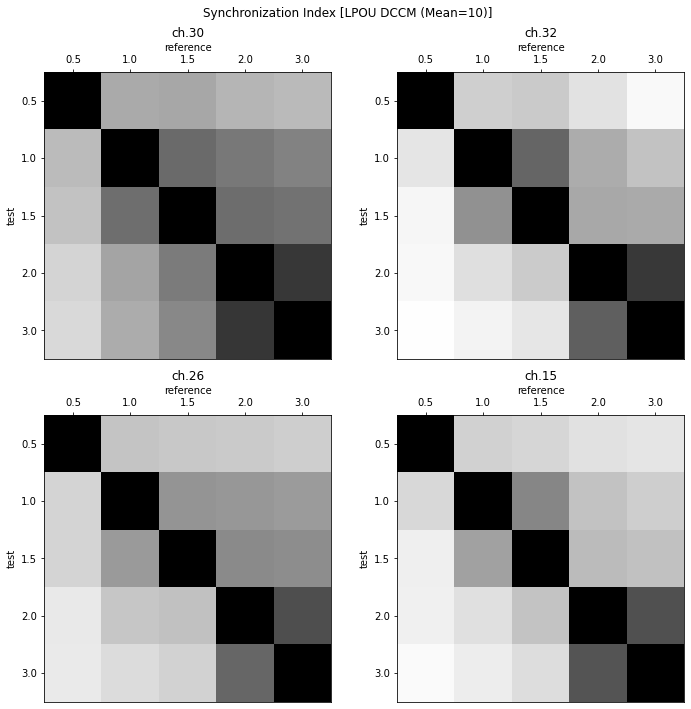

In [22]:
fig, ax = plt.subplots(2,2)
c2=0
fig.suptitle('Synchronization Index [LPOU DCCM (Mean=10)]')
for channelnumber in channelnumbers:
    ax.flatten()[c2].imshow(synchMatrix[:,:,c2], vmin = 0, vmax = 1, cmap = 'Greys')
    ax.flatten()[c2].set_yticks(np.arange(len(amp_list)))
    ax.flatten()[c2].set_yticklabels(np.array(amp_list))
    ax.flatten()[c2].set_ylabel('test')
    ax.flatten()[c2].set_xticks(np.arange(len(amp_list)))
    ax.flatten()[c2].set_xticklabels(np.array(amp_list))
    ax.flatten()[c2].set_xlabel('reference')
    ax.flatten()[c2].xaxis.tick_top()
    ax.flatten()[c2].xaxis.set_label_position('top')
    ax.flatten()[c2].set_title('ch.'+str(channelnumber))
    # ax.flatten()[c2].set_ylabel('mean')
    c2+=1
fig.set_size_inches(10, 10)
fig.tight_layout()

In [23]:
synchMatrix[:,:,1]

array([[1.        , 0.296875  , 0.3125    , 0.203125  , 0.046875  ],
       [0.18518519, 1.        , 0.67407407, 0.42962963, 0.34814815],
       [0.07329843, 0.51832461, 1.        , 0.43979058, 0.43455497],
       [0.05637982, 0.21661721, 0.3115727 , 1.        , 0.8189911 ],
       [0.00883002, 0.10154525, 0.17660044, 0.69536424, 1.        ]])

# Reliablity (Crosscorrelation Measure)
A new correlation-based measure of spike timing reliability <br>
DOI = {10.1016/s0925-2312(02)00838-x}

In [24]:
def reliablityCorr(SpikeTrainList, sigma, tAxis):
    filteredFiringRates = []
    for spikeTrain in SpikeTrainList:
        filteredFiringRate = np.zeros_like(tAxis)
        for spikeTime in spikeTrain:
            filteredFiringRate += 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(tAxis-spikeTime)**2/(2*sigma**2))
        filteredFiringRates.append(filteredFiringRate.copy())

    reliablity = 0
    for i in range(len(filteredFiringRates)-1):
        for j in np.arange(i+1,len(filteredFiringRates)):
            reliablity += np.sum(filteredFiringRates[i]*filteredFiringRates[j]) / (np.linalg.norm(filteredFiringRates[i])*np.linalg.norm(filteredFiringRates[j]))

    return reliablity*2/len(SpikeTrainList)/(len(SpikeTrainList)-1)

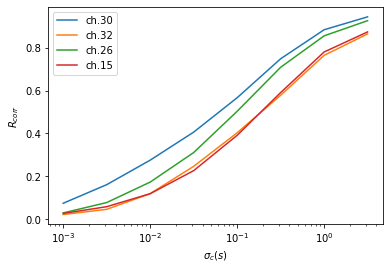

In [25]:
sigma_list = 10**np.arange(-1,3,0.9) *dt
for ci in range(len(channelnumbers)):
    reliablityCurve = []
    for sigma in sigma_list:
        reliablityCurve.append(reliablityCorr(Spike2DList[:,ci], sigma, np.arange(0,300,dt)))
    plt.plot(sigma_list, reliablityCurve, label = 'ch.'+str(channelnumbers[ci]))
plt.legend()
plt.ylabel(r'$R_{corr}$')
plt.xlabel(r'$\sigma_c (s)$')
plt.xscale('log')

In [26]:
sigma = 1*dt

reliablityMatrix = np.ones((len(amp_list),len(amp_list),len(channelnumbers)))
for ch in range(len(channelnumbers)):
    for i1 in range(len(amp_list)-1):
        for i2 in np.arange(i1+1,len(amp_list)):
            if i1==i2: continue
            reliablityMatrix[i1,i2,ch] = reliablityCorr(Spike2DList[[i1,i2],ch], sigma, np.arange(0,300,dt))
            # reliablityMatrix[i2,i1,ch] = reliablityMatrix[i1,i2,ch]

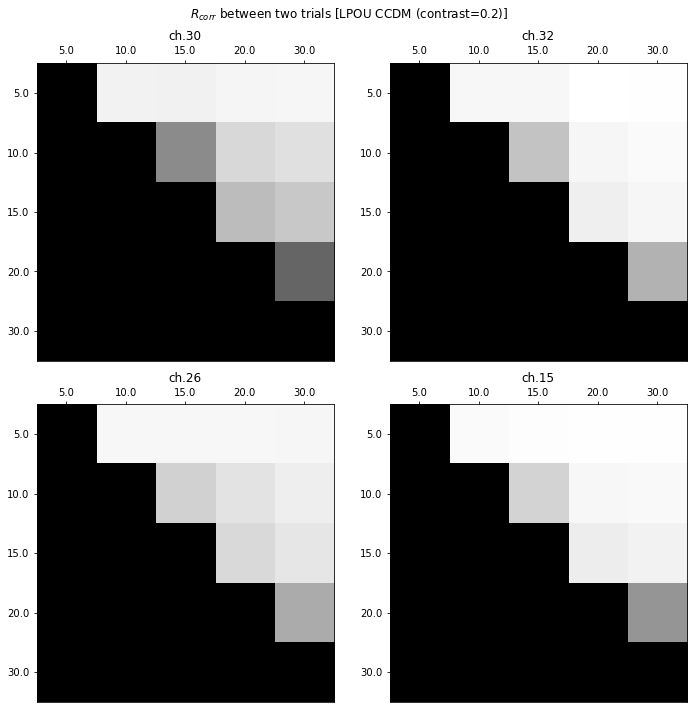

In [27]:
fig, ax = plt.subplots(2,2)
c2=0
fig.suptitle(r'$R_{corr}$ between two trials [LPOU CCDM (contrast=0.2)]')
for channelnumber in channelnumbers:
    ax.flatten()[c2].imshow(reliablityMatrix[:,:,c2], vmin = 0, vmax = 1, cmap = 'Greys')
    ax.flatten()[c2].set_yticks(np.arange(len(amp_list)))
    ax.flatten()[c2].set_yticklabels(np.array(amp_list)*Mean)
    # ax.flatten()[c2].set_ylabel('test')
    ax.flatten()[c2].set_xticks(np.arange(len(amp_list)))
    ax.flatten()[c2].set_xticklabels(np.array(amp_list)*Mean)
    # ax.flatten()[c2].set_xlabel('reference')
    ax.flatten()[c2].xaxis.tick_top()
    ax.flatten()[c2].xaxis.set_label_position('top')
    ax.flatten()[c2].set_title('ch.'+str(channelnumber))
    # ax.flatten()[c2].set_ylabel('mean')
    c2+=1
fig.set_size_inches(10, 10)
fig.tight_layout()

In [28]:
reliablityMatrix[:,:,0]

array([[1.        , 0.10927045, 0.11526471, 0.0798839 , 0.07618479],
       [1.        , 1.        , 0.53587708, 0.25299511, 0.21265237],
       [1.        , 1.        , 1.        , 0.37514832, 0.32476213],
       [1.        , 1.        , 1.        , 1.        , 0.67562953],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])